In [1]:
from model_utils import *

In [2]:
FILE = "./data/filtered_elmundo.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128

In [3]:
# classifier label set
target_label = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [4]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    df.describe()
    labels = df['category'].tolist()
    titles = df['title'].tolist()
    stand_first = df['stand_first'].tolist()
    contents = df['content'].tolist()
    contents = [h + s + d for h, s, d in zip(titles, stand_first, contents)]
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [5]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [6]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE,'JSON',1)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = TestDataset(labels,encoding_list,contents,source_label_dic)
print("data loaded \n {}".format(len(valid_dataset)))
      
# dataloader
loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

Data loaded label:4520 content:4520 


100%|██████████| 4520/4520 [00:02<00:00, 1867.62it/s]

Tokenizer loaded...
encoding time costs: 7.564336776733398
data loaded 
 4520


In [7]:
if not os.path.exists('./{}-valid-results'.format(DATASET_NAME)):
    os.makedirs('./{}-valid-results'.format(DATASET_NAME))
if not os.path.exists('./{}-valid-results/{}'.format(DATASET_NAME, MAX_SEQ_LENGTH)):
    os.makedirs('./{}-valid-results/{}'.format(DATASET_NAME, MAX_SEQ_LENGTH))

In [8]:
#load model
model = RobertaForSequenceClassification(MODEL_NAME,len(lset))
state_dict = torch.load('./results/3.699999999999999e-05-128/5-18-epoch-4.pth')
model.load_state_dict(state_dict)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

In [9]:
iterator = loader
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator)):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        targets.numpy()
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        for i in range(len(data)):
            print(data['origin_contents'][i])
            print('pred: ',lset[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/36 [00:00<?, ?it/s]

El Manchester City certifica el hundimiento del LiverpoolEl conjunto de Guardiola se impone en Anfield (1-4) y refuerza su liderato: 5 puntos de ventaja sobre el United y 10 sobre los 'reds', con un partido menos.Anfield vivió este domingo el hundimiento de su equipo ante un Manchester City que ve cada día más cerca el regreso de la Premier a sus vitrinas (1-4). Ni un penalti fallado por Gündogan ni un error de Ruben Dias. Nada impidió que el City se aprovechara de dos fallos mayúsculos de Alisson para rematar la exhibición.
pred:  SPORTS
true:  deportes
--------------
El ex delegado de Empleo dice que no sabía "nada" de la Faffe pero tenía a cuatro sobrinos y dos amigos en nómina de la fundaciónAntonio Rivas planta a la comisión parlamentaria de la Faffe tras proclamarse víctima de un escarnio público y exigir disculpasFue delegado provincial de la Consejería de Empleo en Sevilla entre el 31 de mayo de 2000 y el 20 de abril de 2010 y patrono de la Fundación Fondo Andaluz de Formación 

Los trenes turísticos de Galicia: una forma diferente de conocer la región en 11 rutas temáticasLa de los pazos, los vinos de la Ribeira Sacra, los monasterios, los faros... Son algunos de los recorridos que propone la comunidad gallega sobre raíles. Están disponibles hasta el mes de octubre.Algunas de las bucólicas imágenes que acompañan estas líneas parecen tomadas en Suiza, pero no, es Galicia. Y en concreto, los parajes por los que discurren las 11 rutas en trenes turísticos de la comunidad autónoma. Cada una ellas versa sobre un tema, de los pazos a los vinos, de los monasterios a los faros, y estarán disponibles todo el verano hasta el próximo 9 de octubre. 
pred:  TRAVEL
true:  cultura
--------------
Mike Tyson anuncia su regreso al ring: "Voy a pelear tres o cuatro veces por causas benéficas"El exboxeador estadounidense Mike Tyson, quien fuera campeón del mundo de los pesos pesados, ha anunciado su regreso a los rings por causas "benéficas" gracias a una exigente entrenamiento 

RTX 3080Ti y RTX 3070Ti, las nuevas tarjetas gráficas de NvidiaNvidia asegura que su modelo de alta gama es un 50% más potente que su predecesor Nvidia ha presentado en el marco de la feria de informática Computex 2021 en Taipei (Taiwán) su nuevo buque insignia en su catálogo de tarjetas gráficas de gama alta para 'gaming', GeForce RTX 3080 Ti, un 50 por ciento más rápida que la generación anterior, que llega junto al nuevo modelo RTX 3070 Ti.
pred:  ARTS & CULTURE
true:  tecnologia
--------------
"Siempre contigo, compañero Rubalcaba"La viuda del ex secretario general del PSOE recuerda que Alfredo Pérez Rubalcaba eligió "el camino difícil de la política" y que "nunca se arrepintió" A tono con la elevada intensidad emocional que ha presidido el 40º Congreso Federal del PSOE, la jornada de clausura se abrió con un homenaje a Alfredo Pérez Rubalcaba, ex secretario general y ex vicepresidente del Gobierno, fallecido en 2019 a los 67 años. Fue un momento que conmovió a las más de nueve mil

El pelotazo de Djokovic: de la disculpa de Carreño a la burla de KyrgiosEl australiano, que ya había criticado al serbio hace unas semanas, se mofó de él tras su descalificación.La descalificación de Novak Djokovic metió a Pablo Carreño en cuartos de final del US Open. El asturiano se medirá este martes al canadiense Denis Shapovalov por un puesto en semifinales, un peldaño al que ya llegó en 2017. En rueda de prensa, Carreño disculpó el gesto del serbio, pero fue claro: "Las reglas son las reglas".
pred:  SPORTS
true:  deportes
--------------
Miguel Pita: "Muchos virus de otras especies saltan a la nuestra pero su llave no entra en nuestra cerradura"MIGUEL PITA (Madrid, 1976). Doctor en Genética y Biología Celular y profesor e investigador en la Universidad Autónoma de Madrid. En su libro Un día en la vida de un virus (Periférica) desvela los secretos de esos seres microscópicos.
pred:  WELLNESS
true:  economia
--------------
Cinco heridos al arrollar un coche la terraza de un bar en 

Elogio de la esquina"La esquina te lleva de vuelta a casa, te dice cómo cubrirte, te espera siempre, te enciende la luz, te da una colleja"La misma noche en que Miriam Gutiérrez levantaba los brazos por última vez, los bajaba para siempre su compañero de guanteo David Gistau.
Fue el pasado 29 de noviembre. Miriam se proclamaba campeona del mundo interina del peso ligero de la WBA y David se desvanecía unas horas antes lejos de allí. Restañadas las heridas de la púgil, Miriam quiso llevarle en varias ocasiones al Clínico San Carlos el cinturón que había ganado. "Es para que despierte", decía. La hicimos desistir. Ella le llamaba El 
pred:  MEDIA
true:  deportes
--------------
Despierta tu lado voyeur y descubre los edificios más emblemáticos de MadridLa sexta edición del festival más esperado del año por los amantes de la arquitectura abrirá las puertas de 50 espacios cerrados al público y ofrecerá la posibilidad de realizar visitas exteriores y online de los edificios más bellos y embl

Paula Badosa se clasifica para semifinales y sigue soñando en Indian Wells Badosa es la primera tenista de España en llegar a semifinales del conocido como "quinto Grand Slam" desde Conchita Martínez en 2003La tenista española Paula Badosa se clasificó este jueves para las semifinales de Indian Wells tras vencer a la alemana Angelique Kerber por 6-4 y 7-5 en una hora y 26 minutos. La española se medirá en semifinales a la tunecina Ons Jabeur.
pred:  GROUPS VOICES
true:  deportes
--------------
Moncloa coordinó los discursos de Felipe González, Zapatero y Pedro Sánchez para escenificar la unidad del PSOESocialdemocracia y unidad son los dos conceptos que marcarán el "hilo conductor" del discurso de Sánchez en el congreso socialistaFelipe González enterró el hacha de guerra, Pedro Sánchez se reconcilió con el pasado del PSOE, José Luis Rodríguez Zapatero levantó acta del momento con pasión y los socialistas salieron tonificados y reconfortados después de años de peleas. La foto
pred:  WO

El corazón de un campeón: Llull mantiene con vida al Real Madrid tras una épica remontada final ante el EfesLos blancos, con un asombroso parcial final de 19-2, salvan el match ball ante un rival que parecía tener todo controlado con la exhibición de Micic. El jueves, cuarto duelo, en el WiZinkHabría que diseccionar a fondo el cerebro de Sergio Llull para encontrar las razones que le llevan a creer en imposibles, a ver resquicios para la rebelión donde todos los demás intuyen un muro. No es la primera vez, pero no deja de sorprender su amor propio. Pocos jugadores encontró la historia del baloncesto con semejante corazón. Lo más probable es que el Real Madrid no esté en la próxima Final Four de Colonia, pero ahí quedan esos casi cinco minutos, para el recuerdo, para que los que algún día tengan que tomar el relevo del balear sepan de lo que fue capaz. [80-76: Narración y estadísticas]
pred:  WELLNESS
true:  deportes
--------------
ABBA llega a TikTok con el anuncio de nuevas canciones 

El martirio de Giménez con las lesiones: "Su mecánica de juego le lleva a ir casi al límite en cada acción"El martes, frente al Liverpool, podría perderse su partido 50 en tres años. Abandonó la concentración de Uruguay, tras sufrir una lesión en los abductoresEl próximo martes, José María Giménez (1995) podría perderse su partido número 50 con el Atlético en los últimos tres años. Pasadas las 12.30 horas de este viernes, el defensa salía del Cerro del Espino al volante de su coche, con la ropa de entrenamiento del equipo. Como ya ocurrió el jueves, había saltado al césped e incluso tocado balón. Lo hizo, eso sí, al margen del grupo. Su deseo es jugar ante el Liverpool y estar al frente de ese muro contra los chicos de Klopp. Pero en el club saben por experiencia que con Giménez es mejor ir con cautela. Ha sufrido 16 percances físicos desde 2018 y cualquier acelerón puede desembocar en un problema más serio. Hace una semana, durante el choque entre Uruguay y Colombia, se sentó en el su

Dieta de la sandía, cinco días para perder un par de kilos de forma deliciosa y seguraYa lo sabemos: una dieta equilibrada debe incluir al menos dos raciones de verdura en las dos comidas principales y dos o tres piezas medianas de fruta al día. Y, de entre todas las posibilidades, en verano hay una que destaca por encima de las demás: la sandía. Es "muy diurética, por lo que ayuda a eliminar toxinas de manera natural", afirma Vanessa Dolz, nutricionista y dietista de una compañía que conoce esta fruta como pocas, Sandía Fashion. Por eso, y porque una rodaja de unos 200 grs. solo aporta unas 40 kcal, la sandía es también uno de nuestros alimentos aliados para ponernos a plan. En concreto, con la dieta de la sandía.
pred:  WELLNESS
true:  deportes
--------------
El regreso de los talibán20 años después de ser derrocados, avanzan imparables en Afganistán. Kabul, la capital, está cada vez más cerca de caer¿Quién es este grupo fundamentalista islámico? ¿Por qué están de vuelta? ¿Por qué es

Toca enmendar el legado de Celaá La nueva ministra de Educación, Pilar Alegría, parece decidida a corregir parte del legado recibido de su antecesora.Una de las áreas en la que más calamitosa ha sido la gestión del Ejecutivo sanchista es la educación. Las políticas implementadas se han caracterizado por un inadmisible sectarismo y por primar los clichés ideológicos sobre cuestiones medulares como la cultura del esfuerzo, la calidad de la enseñanza o el combate del fracaso escolar. Sánchez fulminó a Celaá consciente de que tenía en contra al conjunto de la comunidad educativa y de que su labor al frente del ministerio había sido un desastre. H
pred:  POLITICS
true:  economia
--------------
Aumenta la indignación policial contra la Generalitat por "minimizar" la violencia contra los agentesLos sindicatos denuncian un nuevo episodio de "violencia extrema contra todo policía" en la fiesta Mayor de VacarissesA una semana de la manifestación convocada en Barcelona, los Mossos d'Esquadra y lo

In [10]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/hu/anaconda3/envs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


7 26


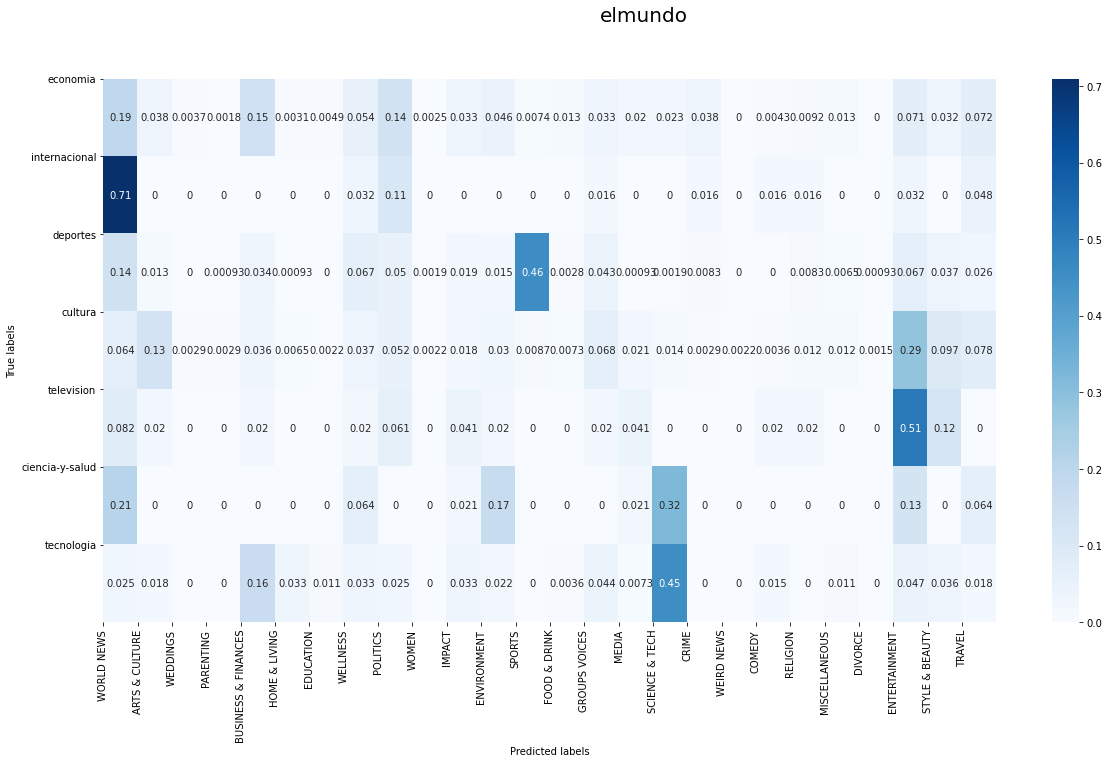

In [13]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))